# **PINN**

### **Objetivo:** Realizar inferencias con la arquitectura PINN optimizada.

**Descripción:** Utilizando los reanálisis de 00, 06, 12 y 18Z, el modelo aprende a inferir el estado en el tiempo *t + 6 hs*, a partir de el estado en el tiempo *t*, y de las ecuaciones de pronóstico estacionarias en el tiempo *t + 6 hs.*

Además, el modelo aprende a inferir el estado *t + 12 hs* a partir de su inferencia previa del tiempo *t + 6 hs.* Esto permite que el modelo sea más estable en evoluciones a largo plazo.

El estado queda definido por las siguientes variables (el aprendizaje temporal queda implícito en el modelo).

**Variables:**
1. componente zonal del viento (u)
2. Componente meridional del viento (v)
3. temperatura (temp)
4. altura geopotencial (alt_geop)

**Entrada:** Datos de reanálisis. Corresponde al tiempo *t.*
- longitud, latitud, u, v, temperatura y altura geopotencial

**Salida:** Inferencias, correspondientes al tiempo *t + 6hs.*
- u, v, temperatura y altura geopotencial

**Función de pérdida (MSE):**
1. Pérdida de datos etiquetados de las variables de salida, comparando el reanálisis y la inferenicia correspondientes a *t + 6 hs.*
2. Pérdida de datos etiquetados de las variables de salida, comparando el reanálisis y la inferenicia correspondientes a *t + 12 hs.*
3. Pérdida por física, optimizando las ecuaciones de pronóstico estacionarias, utilizando las inferenicas, en el *t + 6 hs.*
4. Pérdida por física, optimizando las ecuaciones de pronóstico estacionarias, utilizando las inferenicas, en el *t + 12 hs.*

**Normalizaciones:**
- Variables físicas por media/desvío estándar (M=0, SD=1).
- Variables espaciales por mínimo/máximo [0, 1].

**Hiperparámetros del modelo:**
- Tres capas en total, una oculta con 12 neuronas.
- Función de activación: tangente hiperbólica. Dominio (-inf, inf). Rango (-1, 1).
- Learning rate:
  - *Cosine learning-rate schedule* de 0,00300 a 0.00010
- Épocas: 15
- Coeficientes de pérdidas: Datos: 1,000 y EDP: 0,015.

In [1]:
# Instala librerías necesarias
!apt-get install -y libeccodes-data libeccodes-dev
!pip install torch torchvision torchaudio scipy
!pip install basemap
!pip install basemap-data-hires

"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa las librerias necesarias
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from netCDF4 import Dataset
import os
import gc

from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Definir y verificar el dispositvo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("¿PyTorch detecta CUDA?:", torch.cuda.is_available())
print("Versión de CUDA en PyTorch:", torch.version.cuda)
print("GPU detectada:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Ninguna")

¿PyTorch detecta CUDA?: True
Versión de CUDA en PyTorch: 12.1
GPU detectada: NVIDIA GeForce RTX 3060


In [4]:
# Define las rutas a los archivos
"""
1: Geopotential: m**2 s**-2 (instant): isobaricInhPa: level 500: fcst time 0 hrs
2: Temperature: K (instant): isobaricInhPa :level 500: fcst time 0 hrs
3: U component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs
4: V component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs

Continua con 06Z, 12Z y 18Z respestando el orden.
"""
ruta_notebook = os.getcwd()
ruta_dir_padre = os.path.dirname(ruta_notebook)
ruta_files = ruta_dir_padre + '/files/'

filename_train = ruta_files + '200401201501.nc'
filename_test = ruta_files + '2018120100.nc'
model_path = ruta_dir_padre + '/Artefactos/modelo_PINN.pth'

In [5]:
# Cargar datos desde GRIB
def load_nc_data(filename):
    # Abre el archivo
    ds = Dataset(filename, mode='r')
    #print(ds.variables)
    
    # Selecciona las variables de interés
    alt_geop = ds.variables['z'][:].squeeze()        # Altura del geopotencial [m^2*S^-2]
    u = ds.variables['u'][:].squeeze()               # Componente zonal del viento [m/s]
    v = ds.variables['v'][:].squeeze()               # Componente meridional del viento [m/s]
    temp = ds.variables['t'][:].squeeze()            # Temperatura [K]
    lat = ds.variables['latitude'][:]                # Latitud [º Norte]
    lon = ds.variables['longitude'][:]               # Longitud [º Este]

    # Crear la retícula de puntos equiespaciaods
    lons, lats = np.meshgrid(lon, lat)

    # Extraer los valores para todos los tiempos: (Tiempo, Latitud, Longitud)
    alt_geop = np.array(alt_geop)
    temp = np.array(temp)
    u = np.array(u)
    v = np.array(v)
    lons = np.array(lons)
    lats = np.array(lats)

    # Calculo Parámetro de Coriolis
    f = 2*(7.292*(10**(-5)))*np.sin(np.radians(lats))      # [1/s]

    # Convertir latitud y longitud a coordenadas en metros
    R = 6371000  # Radio terrestre en metros
    lat0, lon0 = -60, -80  # Origen de coordenadas

    x = R * np.cos(np.radians(lat0)) * np.radians(lons - lon0)
    y = R * np.radians(lats - lat0)

    return f, x, y, u, v, temp, alt_geop

In [6]:
# Función para normalización Min-Max
def min_max_normalize(data):
    data_min = np.min(data)
    data_max = np.max(data)

    if data_max == data_min:
        return np.zeros_like(data)  # Evita divisiones por cero en caso de valores constantes

    return (data - data_min) / (data_max - data_min)

In [7]:
# Función para normalización z-score de datos de entrenamiento
def z_score_train_normalize(data):
    mean = np.mean(data)
    std = np.std(data)

    if std == 0:
        return np.zeros_like(data)  # Evita divisiones por cero si los datos son constantes

    return mean, std, (data - mean) / std

In [8]:
# Función para normalización z-score
def z_score_normalize(data, mean, std):

    return (data - mean) / std

In [9]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 12),  # Entrada en to: [x, y, u, v, temp, alt_geop] a capa oculta
            nn.Tanh(),
            nn.Linear(12, 4)   # capa oculta a Salida en to + Δt: [u, v, temp, alt_geop]
        )

    def forward(self, x, y, u, v, temp, alt_geop):
        inputs = torch.cat([x, y, u, v, temp, alt_geop], dim=1)
        output = self.net(inputs)
        u_pred, v_pred, temp_pred, alt_geop_pred = output[:, 0:1], output[:, 1:2], output[:, 2:3], output[:, 3:4]

        return u_pred, v_pred, temp_pred, alt_geop_pred

In [10]:
# Cargar datos de entrenamiento
"""
Dimensiones:

Variables físicas [tiempo, latitud, longitud]: (4*365, 161, 121)
Variables espaciales [latitud, longitud]: (161, 121)
"""
f, x, y, u_train, v_train, temp_train, alt_geop_train = load_nc_data(filename_train)

In [11]:
# Cargar datos de prueba
"""
Dimensiones:

Variables físicas [u, v, temperatura, altura geopotencial]: (4*1, 161, 121)
Variables espaciales [latitud, longitud]: (161, 121)
"""
*_, u_test, v_test, temp_test, alt_geop_test = load_nc_data(filename_test)

In [12]:
# Normalizar variables espaciales de entrada
x = min_max_normalize(x)
y = min_max_normalize(y)

In [13]:
# Tensorizar datos de entrada espacial
"""
Dimensiones de los Tensores: torch.Size([19481, 1]), debido a 161 x 121 = 19481
"""
x_tensor = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

In [14]:
# Normalizar datos de entrenamiento
u_train_mean, u_train_std, u_norm_train = z_score_train_normalize(u_train)
v_train_mean, v_train_std, v_norm_train = z_score_train_normalize(v_train)
temp_train_mean, temp_train_std, temp_norm_train = z_score_train_normalize(temp_train)
alt_geop_train_mean, alt_geop_train_std, alt_geop_norm_train = z_score_train_normalize(alt_geop_train)

In [15]:
# Normalizar datos de prueba
u_norm_test = z_score_normalize(u_test, u_train_mean, u_train_std)
v_norm_test = z_score_normalize(v_test, v_train_mean, v_train_std)
temp_norm_test = z_score_normalize(temp_test, temp_train_mean, temp_train_std)
alt_geop_norm_test = z_score_normalize(alt_geop_test, alt_geop_train_mean, alt_geop_train_std)

In [16]:
# Tensorizar las entradas del modelo
u_tensor_test = torch.tensor(u_norm_test.reshape(-1, 1), dtype=torch.float32)
v_tensor_test = torch.tensor(v_norm_test.reshape(-1, 1), dtype=torch.float32)
temp_tensor_test = torch.tensor(temp_norm_test.reshape(-1, 1), dtype=torch.float32)
alt_geop_tensor_test = torch.tensor(alt_geop_norm_test.reshape(-1, 1), dtype=torch.float32)

In [17]:
# Mover los tensores espaciales a la GPU
x_tensor = x_tensor.to(device)
y_tensor = y_tensor.to(device)

In [18]:
# Mover los tensores físicos a la GPU
def move_tensors(u_tensor_move, v_tensor_move, temp_tensor_move, alt_geop_tensor_move, dispositivo=device):
    u_tensor_move = u_tensor_move.to(dispositivo)
    v_tensor_move = v_tensor_move.to(dispositivo)
    temp_tensor_move = temp_tensor_move.to(dispositivo)
    alt_geop_tensor_move = alt_geop_tensor_move.to(dispositivo)

    return u_tensor_move, v_tensor_move, temp_tensor_move, alt_geop_tensor_move

In [19]:
# Mover los tensores (t=0) de entrada, usados durante la inferencia, a device
u_tensor_test, v_tensor_test, temp_tensor_test , alt_geop_tensor_test = move_tensors(u_tensor_test, v_tensor_test, temp_tensor_test , alt_geop_tensor_test)

In [20]:
# Dominio de trabajo
lat_N = -20
lat_S = -60
lon_W = -80
lon_E = -50

In [21]:
# Carga el modelo previamente entrenado desde el artefacto
modelo = PINN()
modelo.load_state_dict(torch.load(model_path))
modelo.to(device)
modelo.eval()  # Modo evaluación

C:\Users\fabri\AppData\Local\Temp\ipykernel_29020\1113931778.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo.load_state_dict(torch.load(model_path))


PINN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=4, bias=True)
  )
)

In [22]:
# Realizar inferencias, utilizar el modelo para inferir las variables en el tiempo +6hs desde el inicio
with torch.no_grad():  # Deshabilitar la retropropagación ya que estamos solo haciendo inferencia
    u_pred_6h, v_pred_6h, temp_pred_6h, alt_geop_pred_6h = modelo(x_tensor, y_tensor, u_tensor_test, v_tensor_test, temp_tensor_test, alt_geop_tensor_test)

In [23]:
# Mover los tensores (t=6) de entrada, usados durante la inferencia, a device
u_tensor_pred_6h, v_tensor_pred_6h, temp_tensor_pred_6h, alt_geop_tensor_pred_6h = move_tensors(u_pred_6h, v_pred_6h, temp_pred_6h, alt_geop_pred_6h)

In [24]:
# Realizar inferencias, utilizar el modelo para inferir las variables en el tiempo +12hs desde el inicio
with torch.no_grad():  # Deshabilitar la retropropagación ya que estamos solo haciendo inferencia
    u_pred_12h, v_pred_12h, temp_pred_12h, alt_geop_pred_12h = modelo(x_tensor, y_tensor, u_tensor_pred_6h, v_tensor_pred_6h, temp_tensor_pred_6h, alt_geop_tensor_pred_6h)

In [25]:
# Convertir las predicciones a +6hs de formato plano a formato espacial (161x121)
u_pred_6h = u_pred_6h.cpu().numpy().reshape(161, 121)
v_pred_6h = v_pred_6h.cpu().numpy().reshape(161, 121)
temp_pred_6h = temp_pred_6h.cpu().numpy().reshape(161, 121)
alt_geop_pred_6h = alt_geop_pred_6h.cpu().numpy().reshape(161, 121)

In [26]:
# Convertir las predicciones a +12hs de formato plano a formato espacial (161x121)
u_pred_12h = u_pred_12h.cpu().numpy().reshape(161, 121)
v_pred_12h = v_pred_12h.cpu().numpy().reshape(161, 121)
temp_pred_12h = temp_pred_12h.cpu().numpy().reshape(161, 121)
alt_geop_pred_12h = alt_geop_pred_12h.cpu().numpy().reshape(161, 121)

In [27]:
# Función desnormalizar z-score
def denormalize_z_score(data_norm, data_mean, data_std):

    return data_norm * data_std + data_mean

In [28]:
# Variables de reanálisis ERA-5 0.25°
ds = Dataset(filename_test, mode='r')
lat = ds.variables['latitude'][:]            # Latitud [º Norte]
lon = ds.variables['longitude'][:]           # Longitud [º Este]

# Crear la retícula de puntos equiespaciaods
lons, lats = np.meshgrid(lon, lat)

# Extraer los valores para todos los tiempos: (Tiempo, Latitud, Longitud)
lons = np.array(lons)
lats = np.array(lats)

In [29]:
# Desnormalizar pronóstico a +6hs
u_pred_6h_np = denormalize_z_score(u_pred_6h, u_train_mean, u_train_std)                              # Componente zonal del viento [m/s]
v_pred_6h_np = denormalize_z_score(v_pred_6h, v_train_mean, v_train_std)                              # Componente meridional del viento [m/s]
temp_pred_6h_np = denormalize_z_score(temp_pred_6h, temp_train_mean, temp_train_std)                  # Temperatura [K]
alt_geop_pred_6h_np = denormalize_z_score(alt_geop_pred_6h, alt_geop_train_mean, alt_geop_train_std)  # Altura Geopotencial [m]

In [30]:
# Desnormalizar pronóstico a +12hs
u_pred_12h_np = denormalize_z_score(u_pred_12h, u_train_mean, u_train_std)                              # Componente zonal del viento [m/s]
v_pred_12h_np = denormalize_z_score(v_pred_12h, v_train_mean, v_train_std)                              # Componente meridional del viento [m/s]
temp_pred_12h_np = denormalize_z_score(temp_pred_12h, temp_train_mean, temp_train_std)                  # Temperatura [K]
alt_geop_pred_12h_np = denormalize_z_score(alt_geop_pred_12h, alt_geop_train_mean, alt_geop_train_std)  # Altura Geopotencial [m]

In [31]:
# Variables generadas +6hs
V_pred_6h_np = np.sqrt(np.square(u_pred_6h_np) + np.square(v_pred_6h_np))      # Intensidad del viento [m/s]

In [32]:
# Variables generadas +12hs
V_pred_12h_np = np.sqrt(np.square(u_pred_12h_np) + np.square(v_pred_12h_np))      # Intensidad del viento [m/s]

In [33]:
# Cambio de unidades variables predicción +6hs
V_pred_6h_np = 1.94 * V_pred_6h_np                     # Intensidad del viento [kt]
temp_pred_6h_np = temp_pred_6h_np - 273.15             # Temperatura [ºC]
alt_geop_pred_6h_np = (1/9.8)*alt_geop_pred_6h_np      # Altura Geopotencial [m]

In [34]:
# Cambio de unidades variables predicción +12hs
V_pred_12h_np = 1.94 * V_pred_12h_np                     # Intensidad del viento [kt]
temp_pred_12h_np = temp_pred_12h_np - 273.15             # Temperatura [ºC]
alt_geop_pred_12h_np = (1/9.8)*alt_geop_pred_12h_np      # Altura Geopotencial [m]

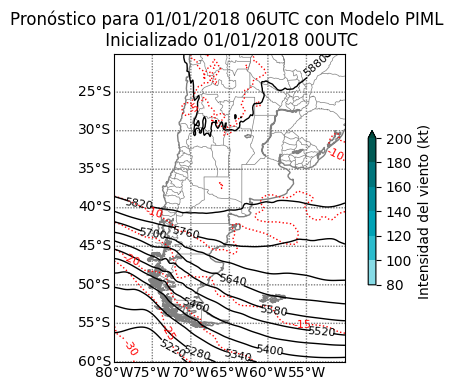

In [35]:
# Crear la figura
plt.figure(figsize=(5, 4))

# Crear el mapa con Basemap
m = Basemap(projection='cyl', resolution='l', llcrnrlat=lat_S, urcrnrlat=lat_N, llcrnrlon=lon_W, urcrnrlon=lon_E)

# Dibujar costas y países
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawparallels(np.arange(-60,-20,5.0),labels=[1,0,0,1], color='gray')
m.drawmeridians(np.arange(-80,-50,5.0),labels=[1,1,0,1], color='gray')

# Graficar la temperatura en isolíneas punteadas cada 5ºC
temp_levels = np.arange(-50, 25, 5)
temp_contours = m.contour(lons, lats, temp_pred_6h_np, levels=temp_levels, linewidths=1, colors='red', linestyles='dotted')
plt.clabel(temp_contours, inline=True, fontsize=8, fmt='%1.0f')

# Graficar la altura geopotencial en línea sólida cada 60 mgp
geopotential_levels = np.arange(5100, 6060, 60)
geopotential_contours = m.contour(lons, lats, alt_geop_pred_6h_np, levels=geopotential_levels, linewidths=1, colors='black')
plt.clabel(geopotential_contours, inline=True, fontsize=8, fmt='%1.0f')

# Definir los niveles de viento en nudos
wind_levels_knots = [80, 100, 120, 140, 160, 180, 200]
# Crear una paleta personalizada de celestes
cmap_celeste = LinearSegmentedColormap.from_list("celestes", ["#b2ebf2", "#00acc1", "#00838f", "#004d40"])
# Graficar la intensidad del viento con contourf para los niveles especificados
wind_contourf = m.contourf(lons, lats, V_pred_6h_np, levels=wind_levels_knots, cmap=cmap_celeste, extend='max')
# Agregar una barra de colores para la intensidad del viento
plt.colorbar(wind_contourf, label='Intensidad del viento (kt)', shrink=0.5)

# Título y visualización
#plt.title("Campos de Temperatura y Alt. Geopotencial (isolineas)\n Intensidad del viento (sombrado) en 500 hPa\n NN - pronóstico a 6 horas, inicializado 20180101 00UTC")
plt.title("Pronóstico para 01/01/2018 06UTC con Modelo PIML \n Inicializado 01/01/2018 00UTC")
plt.tight_layout()
plt.show()

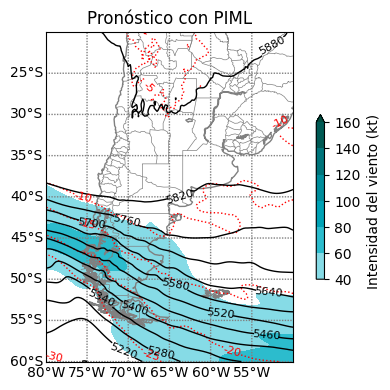

In [36]:
# Crear la figura
plt.figure(figsize=(5, 4))

# Crear el mapa con Basemap
m = Basemap(projection='cyl', resolution='l', llcrnrlat=lat_S, urcrnrlat=lat_N, llcrnrlon=lon_W, urcrnrlon=lon_E)

# Dibujar costas y países
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawparallels(np.arange(-60,-20,5.0),labels=[1,0,0,1], color='gray')
m.drawmeridians(np.arange(-80,-50,5.0),labels=[1,1,0,1], color='gray')

# Graficar la temperatura en isolíneas punteadas cada 5ºC
temp_levels = np.arange(-50, 25, 5)
temp_contours = m.contour(lons, lats, temp_pred_12h_np, levels=temp_levels, linewidths=1, colors='red', linestyles='dotted')
plt.clabel(temp_contours, inline=True, fontsize=8, fmt='%1.0f')

# Graficar la altura geopotencial en línea sólida cada 60 mgp
geopotential_levels = np.arange(5100, 6060, 60)
geopotential_contours = m.contour(lons, lats, alt_geop_pred_12h_np, levels=geopotential_levels, linewidths=1, colors='black')
plt.clabel(geopotential_contours, inline=True, fontsize=8, fmt='%1.0f')

# Definir los niveles de viento en nudos
wind_levels_knots = [40, 60, 80, 100, 120, 140, 160]
# Crear una paleta personalizada de celestes
cmap_celeste = LinearSegmentedColormap.from_list("celestes", ["#b2ebf2", "#00acc1", "#00838f", "#004d40"])
# Graficar la intensidad del viento con contourf para los niveles especificados
wind_contourf = m.contourf(lons, lats, V_pred_12h_np, levels=wind_levels_knots, cmap=cmap_celeste, extend='max')
# Agregar una barra de colores para la intensidad del viento
plt.colorbar(wind_contourf, label='Intensidad del viento (kt)', shrink=0.5)

# Título y visualización
#plt.title("Campos de Temperatura y Alt. Geopotencial (isolineas)\n Intensidad del viento (sombrado) en 500 hPa\n NN - pronóstico a 12 horas, inicializado 20180101 00UTC")
plt.title("Pronóstico con PIML")
plt.tight_layout()
plt.show()